## 1 Introduction

I will be using the Northwind Traders Access database to perform a hypothesis test to answer the following question.  **_Do Different Regions Spend More Per Order than others ?_**<br>   


**Null Hypothesis** <br>
Each region spends roughly the same average price per order <br>

**Alternative Hypothesis** <br>
Certain Regions spend more than others per an order<br>

**Effect Size**<br>
I'm just interested in if one region spends more than another at the moment not which region spends the most.  However, any difference less than 2 standard deviations from the average cost per order of whole data set is worth noting.

**Variables We Are Interested in Determining the Relationship Between**<br>
Price of order after discounts and the region <br>

### 1.1 Loading Libraries

In [1]:
# add every library I will use throughout the project here
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stat
from scipy import stats
from __future__ import print_function


#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#pivot tables for table joining
from pivottablejs import pivot_ui

#for t-tests
from scipy.stats import ttest_ind

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

### 1.2 Retrieve data from database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [3]:
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)


In [4]:
pd.read_sql_query("SELECT * FROM [Order] LIMIT 1;", conn)


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France


In [5]:
invoices = pd.read_sql_query('''SELECT ShipRegion,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Invoice_total,
                            SUM(((od.UnitPrice * (1 - od.Discount)) * od.Quantity)/LENGTH(o.ShipRegion)) Avg_cost
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            GROUP BY ShipRegion
                    ''', conn)
invoices

,ShipRegion,Invoice_total,Avg_cost
0,British Isles,108951.2150,8380.862692
1,Central America,23582.0775,1572.138500
2,Eastern Europe,3531.9500,252.282143
3,North America,295780.9005,22752.376962
4,Northern Europe,87156.1625,5810.410833
5,Scandinavia,24545.2025,2231.382045
6,South America,171855.5055,13219.654269
7,Southern Europe,45225.7175,3015.047833
8,Western Europe,505164.3085,36083.164893


In [6]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
invoices['Region'] = le.fit_transform(invoices['ShipRegion'])

In [7]:
invoices

,ShipRegion,Invoice_total,Avg_cost,Region
0,British Isles,108951.2150,8380.862692,0
1,Central America,23582.0775,1572.138500,1
2,Eastern Europe,3531.9500,252.282143,2
3,North America,295780.9005,22752.376962,3
4,Northern Europe,87156.1625,5810.410833,4
5,Scandinavia,24545.2025,2231.382045,5
6,South America,171855.5055,13219.654269,6
7,Southern Europe,45225.7175,3015.047833,7
8,Western Europe,505164.3085,36083.164893,8


In [8]:
df = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', conn)

In [9]:
df.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [10]:
# Calculating the revenue per sub-order
df['price_per_order'] = df.Quantity * df.UnitPrice * (1 - df.Discount)
# Dropping the columns for quantity, unit price and discount now that we have the total revenue
df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)
# Grouping the data by order and summing the revenue for each order
df = df.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId as we no longer need this
df.drop('OrderId', axis=1, inplace=True)

In [11]:
# Combining Eastern and Southern Europe
df.loc[(df.Region == 'Eastern Europe') | (df.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
# Combining Scandinavia and Northern Europe
df.loc[(df.Region == 'Scandinavia') | (df.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
# Combining Central and South America
df.loc[(df.Region == 'Central America') | (df.Region == 'South America'),'Region'] = 'South and Central America'

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


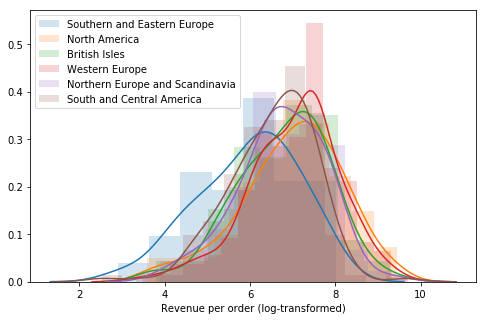

In [12]:
# Copying the dataset and log-transforming price_per_order
df_log = df.copy()
df_log['price_per_order'] = np.log(df['price_per_order'])
# Plotting the distributions for the log-transformed data
plt.figure(figsize=(8,5))
for region in set(df_log.Region):
    region_group = df_log.loc[df_log['Region'] == region]
    sns.distplot(region_group['price_per_order'], hist_kws=dict(alpha=0.2), label=region)
    plt.legend()
    plt.xlabel('Revenue per order (log-transformed)')

In [13]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Region)', df_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),77.999547,5.0,13.032374,3.285724e-12
Residual,951.624641,795.0,NaN,NaN


Conclusions:
There is a statistically significant difference in the average price per order depending upon region.  
Next Steps:
Determine which regions spend the most and which spend the least per region.